In [16]:
using DSP
using WAV
using Plots
using FFTW
using Statistics

In [17]:
function pre_emphasize(signal, alpha=0.95)
    filt_function = PolynomialRatio([1.0, -alpha], [1.0])
    return filt(filt_function, signal)
end

pre_emphasize (generic function with 2 methods)

In [18]:
function make_parabola(x_points, y_points)
    # make parabola
    A = [x_points[1]^2 x_points[1] 1; x_points[2]^2 x_points[2] 1; x_points[3]^2 x_points[3] 1] 
    y = [y_points[1]; y_points[2]; y_points[3]]
    coeffs = A \ y
    a, b, c = coeffs 
    parabola(x) = a * x^2 + b * x + c

    # calculate delta f
    der_1 = (y_points[3] - y_points[1]) / (2*(x_points[2] - x_points[1]))
    der_2 = (y_points[3] - (2*y_points[2]) + y_points[1]) / ((x_points[2] - x_points[1])^2)
    delta = -der_1 / der_2

    return parabola, delta
end

make_parabola (generic function with 1 method)

In [19]:
function find_peaks(; x, y, interpolation::Bool=false, amp_min=-30)
    peak_indices = []
    peaks = []
    current_peak = 0
    wait = false
    global_amp_max = maximum(y)
    for i in [2:1:length(x)-1;]
        prev_i = i-1
        prev = y[prev_i]
        cur = y[i]
        next_i = i+1
        next = y[next_i]
        if (cur == current_peak || (cur - global_amp_max) < amp_min)
            wait = true
        else
            wait = false
        end
        prev_i -= 1
        while (cur == prev && prev_i > 0)
            prev = y[prev_i]
            prev_i -= 1
        end
        next_i += 1
        while (cur == next && next_i <= length(x))
            next = y[next_i]
            next_i += 1
        end
        if (cur > prev && cur > next && wait == false)
            # println("Frequency: $(x[i]) Prev: $(prev), Cur: $(cur), Next: $(next))")
            current_peak = cur
            peak = x[i]
            push!(peak_indices, i)
            if (interpolation==true)
                parabola, delta = make_parabola([x[prev_i], x[i], x[next_i]], [prev, cur, next])
                peak = x[i]+delta
            end
            push!(peaks, peak)
        end
    end
return peaks, peak_indices
end

find_peaks (generic function with 1 method)

In [ ]:
# LPC parameters
window_size = 1000
overlap = 500
order = 46
n = 512
n_formants = 4
formant_cutoff_freq = 4000
min_amplitude = -30

# Formant tracking parameters
f1_prediction = 800
f2_prediction = 1100
f3_prediction = 2800
f4_prediction = 3400
f5_prediction = 4200

# Spectrogram parameters
s_window_size = 600
s_overlap = 300
cutoff_freq = 5000

5000

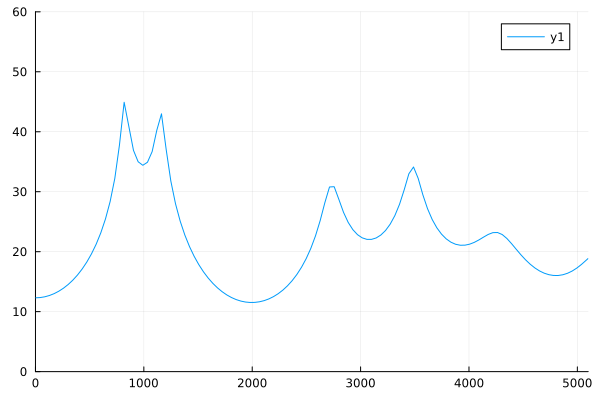

In [21]:
signal, fs, b, opt = wavread("demo_data/aa_audio/audio_lpc_aa_fo160.wav")
signal = signal[1:end]
signal1 = pre_emphasize(signal)
signal2 = pre_emphasize(signal1)
a, e = lpc(signal2, order)
a = vcat(1.0, a)
filt_func = PolynomialRatio([1.0], a)
f = [0:(fs/2)/n:fs/2;]
resp = freqz(filt_func, f, fs)
resp = 20*log10.(abs.(resp))
plot(f, resp, xlim=(0,5100), ylim=(0,60))

In [ ]:
num_windows = div(length(signal) - window_size, window_size - overlap) + 1
windows = []
for i in 1:num_windows
    start_idx = (i - 1) * (window_size - overlap) + 1
    end_idx = start_idx + window_size - 1
    window = signal[start_idx:end_idx]
    windowed_signal = window .* hanning(window_size)
    push!(windows, windowed_signal)
end

43


In [26]:
formant_matrix = []
for i in 1:length(windows)
    a, e = lpc(windows[i], order)
    a = vcat(1.0, a)
    filt_func = PolynomialRatio([1.0], a)
    f = [0:(fs/2)/n:fs/2;]
    resp = freqz(filt_func, f, fs)
    resp = 20*log10.(abs.(resp))
    formants = find_peaks(x=f, y=resp, interpolation=true, amp_min=min_amplitude)
    push!(formant_matrix, formants)
end
println(size(formant_matrix))

(43,)
